# 1EG 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [4]:
df = pd.read_csv('../data/1EG.csv')

In [5]:
df.head()

,POVRSINA,BR_OSOBA,MJESEC_sin,MJESEC_cos,MJESEC,GODINA,S_SNAGA,ENESGR
0,NaN,NaN,-0.866025,0.5,10,2010,0.019850,3.494
1,NaN,NaN,-0.866025,0.5,10,2010,0.009742,1.153
2,NaN,NaN,-0.866025,0.5,10,2010,0.044751,5.955
3,NaN,NaN,-0.866025,0.5,10,2010,0.007539,1.829
4,NaN,NaN,-0.866025,0.5,10,2010,0.053865,4.536


In [6]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 661191 entries, 0 to 661190
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   POVRSINA    268818 non-null  float64
 1   BR_OSOBA    25190 non-null   float64
 2   MJESEC_sin  661191 non-null  float64
 3   MJESEC_cos  661191 non-null  float64
 4   MJESEC      661191 non-null  int64  
 5   GODINA      661191 non-null  int64  
 6   S_SNAGA     661069 non-null  float64
 7   ENESGR      521802 non-null  float64
dtypes: float64(6), int64(2)
memory usage: 40.4 MB


Ako je ENESGR jednako nula ili null to izbacujemo iz skupa

In [23]:
df = df[df['ENESGR'].notna() & (df['ENESGR'] != 0)]

In [52]:
df.info()

<class 'pandas.DataFrame'>
Index: 470856 entries, 0 to 661181
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   POVRSINA    193699 non-null  float64
 1   BR_OSOBA    23095 non-null   float64
 2   MJESEC_sin  470856 non-null  float64
 3   MJESEC_cos  470856 non-null  float64
 4   MJESEC      470856 non-null  int64  
 5   GODINA      470856 non-null  int64  
 6   S_SNAGA     470856 non-null  float64
 7   ENESGR      470856 non-null  float64
 8   cluster     193699 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 35.9 MB


In [53]:
# Sto ako izbacimo sve retke koji za povrsinu imaju 0 ili null? 
# (Od)komentiraj ovaj blok.
df = df[df['POVRSINA'].notna() & (df['POVRSINA'] != 0)]

## Grafovi

### Provjera korelacija

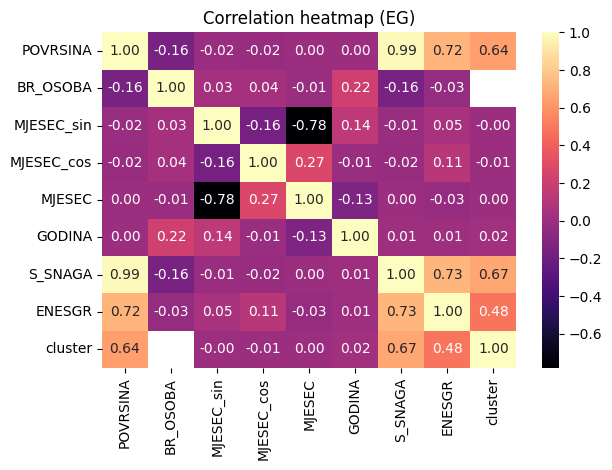

In [54]:
corr = df.corr()

ax = sns.heatmap(corr, cmap="magma", annot=True, fmt=".2f")
ax.set_title("Correlation heatmap (EG)")

plt.tight_layout()
plt.show()

Vidimo da zapravo korelacija izmedu mjeseca i potrosnje nije toliko bitna, ali je snaga na jedinici preko koje se direktno i racuna potrosnja. Takoder vidimo da broj osoba nema utjecaja, ali povrsina je jako korelirana i to cemo koristiti u nastavku.

## Trendovi podataka

In [55]:
def diagnose_features(data, features, target):
    """
    Metoda za graficki pregled trendova u podatcima.
    """
    num_features = len(features)
    rows = (num_features + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, col in enumerate(features):
        # Crtamo podatke i trend
        sns.regplot(
            data=data, 
            x=col, 
            y=target, 
            ax=axes[i],
            scatter_kws={'alpha': 0.2, 's': 10}, 
            line_kws={'color': 'red'},
            lowess=True # Lowess crta liniju koja prati lokalni trend (otkriva zakrivljenost)
        )
        axes[i].set_title(f'{target} vs {col}')
        axes[i].grid(True, linestyle='--', alpha=0.6)

    # Brišemo prazne grafove ako ih ima
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

/Users/dzanijaivan/Developer/AnomalyDetection/.venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


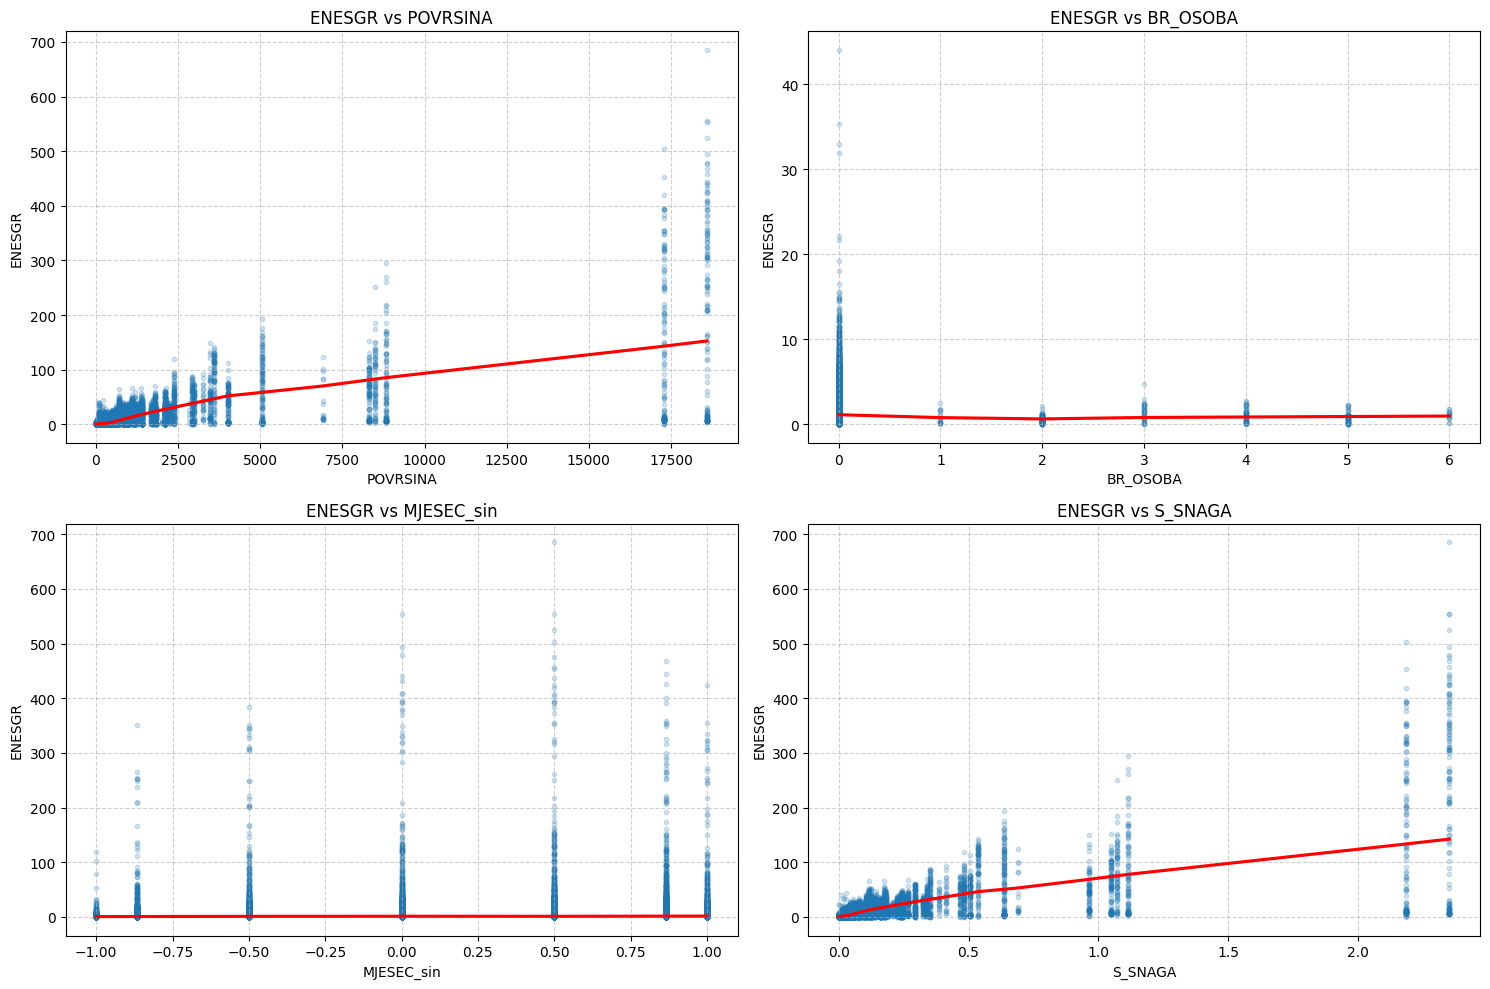

In [56]:
diagnose_features(df, ['POVRSINA', 'BR_OSOBA', 'MJESEC_sin', 'S_SNAGA'], 'ENESGR')

Ovime smo se uvjerili da broj osoba ima zanemariv ucinak na ukupnu potrosnju energije neke jedinice.

## Grupiranje 

### K-sredina

In [57]:
from sklearn.metrics import silhouette_score

def find_optimal_k(data, features, title):
    """
    Metoda za trazenje optimaknog broja grupa k nad podatcima i znacajkama
    """
    
    X_sub = data[features].dropna()
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_sub)
    
    inertia = []
    silhouette_avg = []
    K_range = range(2, 9)

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia.append(kmeans.inertia_)
        
        # Silhouette na uzorku zbog brzine ako je dataset velik
        # Ovo mozda maknuti -> presporo
        sample_size = min(len(X_scaled), 5000)
        idx = np.random.choice(len(X_scaled), sample_size, replace=False)
        current_silhouette = silhouette_score(X_scaled[idx], labels[idx])
        silhouette_avg.append(current_silhouette)
        print(f"{k:<5} | {current_silhouette:<15.4f}")

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Broj klastera (k)')
    ax1.set_ylabel('Inertia (Lakat)', color='blue')
    ax1.plot(K_range, inertia, 'bo-')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Silhouette Score (Više je bolje)', color='red')
    ax2.plot(K_range, silhouette_avg, 'ro-')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title(f'Određivanje optimalnog k za: {title}')
    plt.show()

2     | 0.9863         
3     | 0.9676         
4     | 0.9246         
5     | 0.9055         
6     | 0.5857         
7     | 0.5492         
8     | 0.5120         


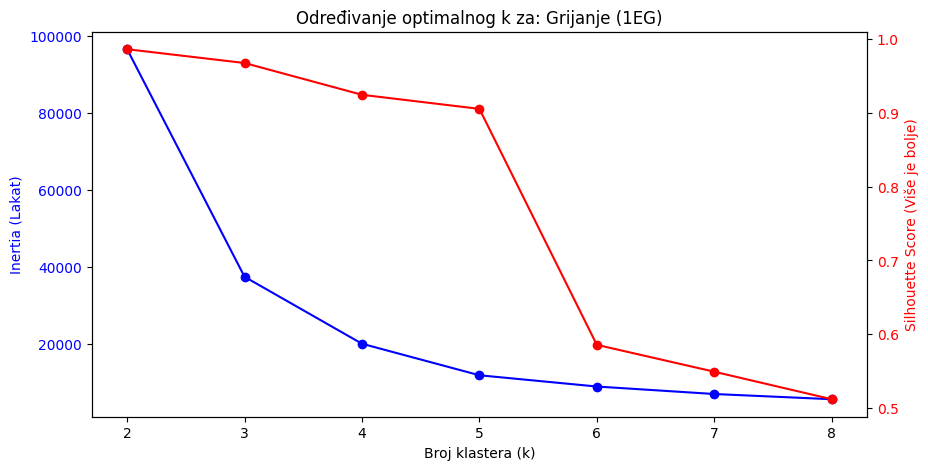

In [58]:
# Procjena optimalnog broja grupa
_features = ['POVRSINA', 'S_SNAGA']
find_optimal_k(df, _features, "Grijanje (1EG)")

Najbolji odabir broja grupa je 3, 4 ili 5 iz ovoga. Nastavljamo sa 3 grupe.

In [59]:
def perform_clustering(data, features, n_clusters=4):
    """ 
    Metoda za grupiranje podataka.
    """
    df_sub = data[features].dropna().copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_sub)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df_sub['cluster'] = kmeans.fit_predict(scaled_data)
    
    return df_sub['cluster']


df['cluster'] = perform_clustering(df, _features, n_clusters=3)
print(f"Klasteri:\n{df['cluster'].value_counts()}")

Klasteri:
cluster
0    192493
2       903
1       260
Name: count, dtype: int64


In [60]:
def plot_clustering_2d(data, features):
    """
    Metoda za graficki prikaz grupa.
    """
    if 'cluster' not in df.columns:
        print("Klasteri nisu pronađeni u DataFrame-u. Molimo pokrenite perform_clustering prvo.")

    # Izracun centroida 
    centroids = df.groupby('cluster')[_features].mean().reset_index()
    
    plt.figure(figsize=(10, 7))
    
    sns.scatterplot(
        data=df, 
        x='POVRSINA', 
        y='S_SNAGA', 
        hue='cluster', 
        palette='viridis', 
        s=50,             
        alpha=0.6,        
        edgecolor='w',    
        legend='full'     
    )
    
    # Crtanje centroida 
    sns.scatterplot(
        data=centroids, 
        x='POVRSINA', 
        y='S_SNAGA', 
        marker='X',        
        s=250,             
        color='red',       
        edgecolor='black', 
        label='Centroidi'  
    )
    
    plt.title('Klasteri i Centroidi')
    plt.xlabel(_features[0])
    plt.ylabel(_features[1])
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.show()

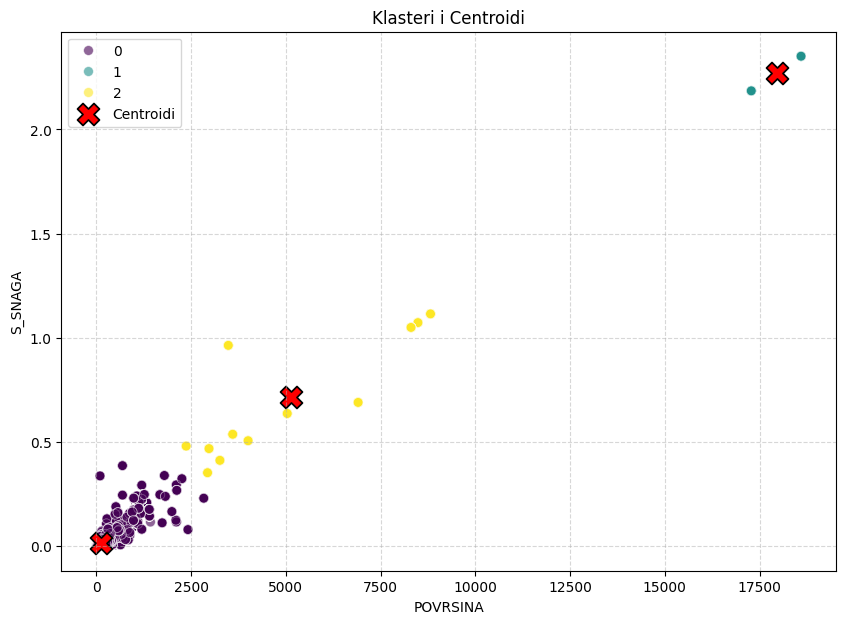

In [61]:
plot_clustering_2d(df, _features)

Ovdje vidimo problem da puno stanova ima vrijednost povrsine 0 (vjerojatno nije nikad mjerena jer ne ulazi u izracun).

## Linearni modeli

In [62]:
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression

def detect_outliers_regression(data, features, target):
    """
    Metoda za odredivanje outliera na temelju linearne regresije.
    """
    df_reg = data.copy().dropna(subset=features + [target])
    
    # 1. Treniranje modela
    X = df_reg[features]
    y = df_reg[target]
    
    model = LinearRegression()
    model.fit(X, y)
    
    # 2. Predvidanje
    df_reg['prediction'] = model.predict(X)
    df_reg['residual'] = df_reg[target] - df_reg['prediction']
    
    # 3. Izracun standardne devijacije reziduala (sigma)
    sigma = np.std(df_reg['residual'])
    
    # Racunamo Z-score za detekciju
    df_reg['z_score'] = zscore(df_reg['residual'])
    
    # Definiramo outliere (izvan +/- 3 sigme)
    outliers = df_reg[df_reg['z_score'] > 3] 
    normals = df_reg[df_reg['z_score'] <= 3]
    
    print(f"Pronadeno {len(outliers)} ekstrema od {len(df_reg)} zapisa (Sigma={sigma:.2f}).")
    
    plt.figure(figsize=(12, 8))
    plt.scatter(normals['prediction'], normals[target], 
                c='blue', alpha=0.3, s=20, label='Normalna potrosnja')
    plt.scatter(outliers['prediction'], outliers[target], 
                c='red', alpha=0.9, s=50, edgecolors='black', label='Outlieri (>3σ)')
    line_x = np.linspace(df_reg['prediction'].min(), df_reg['prediction'].max(), 100)
    plt.plot(line_x, line_x, color='black', linestyle='--', linewidth=2, label='Idealno predvidanje')
    plt.fill_between(line_x, 
                     line_x - 3*sigma, 
                     line_x + 3*sigma, 
                     color='green', alpha=0.15, label='Zona tolerancije (±3σ)')
    
    plt.xlabel(f'Ocekivana potrošnja - Model ({target})')
    plt.ylabel(f'Stvarna potrošnja ({target})')
    plt.title(f'Detekcija Outliera: Stvarno vs. Očekivano\n(Varijable: {", ".join(features)})')
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.show()
    
    return outliers.sort_values(by='z_score', ascending=False)

Pronadeno 629 ekstrema od 193656 zapisa (Sigma=7.06).


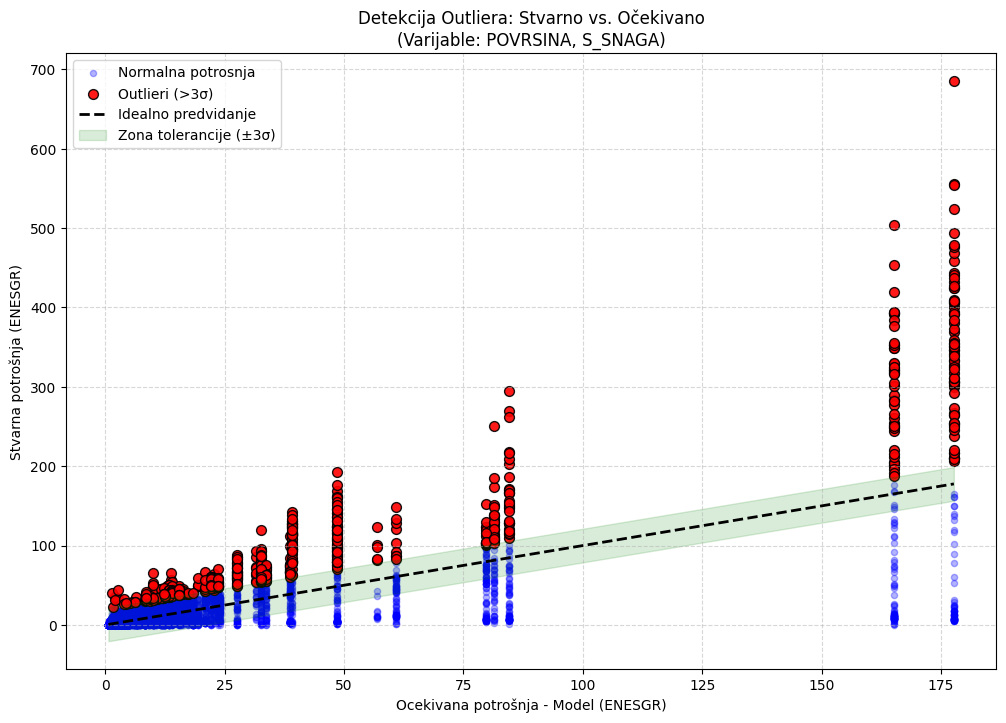

In [63]:
outliers = detect_outliers_regression(df, _features, 'ENESGR')